In [1]:
from openqaoa.qaoa_parameters.baseparams import QAOACircuitParams, QAOAVariationalBaseParams, shapedArray, _is_iterable_empty
import numpy as np
import matplotlib.pyplot as plt
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params, QAOAVariationalStandardParams
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.devices import create_device
from openqaoa.qaoalib import dicke_wavefunction, dicke_basis

from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *

from openqaoa.workflows.optimizer import QAOA
from openqaoa.problems.problem import NumberPartitionm
import numpy as np

Create the hamiltonians

In [2]:
nums=list(np.random.randint(80,100,9))
print(nums)
# nums = [11,139,117,40,87,199,5,3,133]
cost_prob = NumberPartition(nums).get_qubo_problem()
cost_hamil = cost_prob.hamiltonian
n_qubits = cost_hamil.n_qubits

mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

p=4
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=4)

[85, 96, 80, 96, 96, 97, 90, 80, 81]


In [3]:
cost_hamiltonian = circuit_params.cost_hamiltonian
coeffs = cost_hamiltonian.coeffs
terms = cost_hamiltonian.terms
sorted_terms,sorted_coeffs = zip(*sorted(zip(terms,coeffs), key = lambda pair: pair[1]))
sorted_terms = list(sorted_terms)
sorted_coeffs = list(sorted_coeffs)

### kmeans

In [4]:
from sklearn.cluster import KMeans

In [5]:
# Kmeans requires the coefficents to be reshaped
X = np.array(coeffs).reshape(-1, 1)

In [10]:
len(coeffs)

36

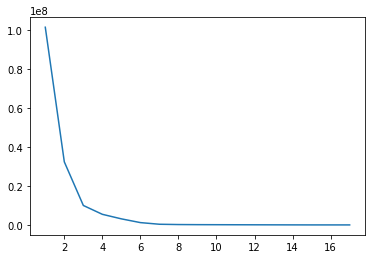

In [20]:
# Here you run kmeans for many as many clusters
wcss = [] 
for i in range(1, int(len(coeffs)/2)): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
plt.plot(range(1, int(len(coeffs)/2)) , wcss)

given the above plot the natural number of clusters is around 3 or 4

In [32]:
kmeans = KMeans(n_clusters=4).fit(X)

In [33]:
kmeans.cluster_centers_

array([[13281.66666667],
       [18528.        ],
       [16843.75      ],
       [15265.625     ]])

I am unsure what's the best way to visualise them. Since they are one dimetional I am just plotting them on the diagonal!

The kmeans centers are plotted in red

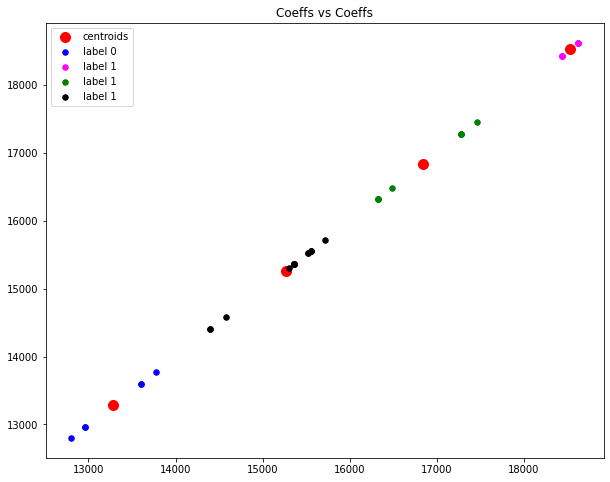

In [97]:
plt.figure(figsize=(10,8))

# Creating the data
x1 = np.array(coeffs)
x2 = np.array(coeffs)
kmeans_centers = [np.mean(X.flatten()[kmeans.labels_==i]) for i in range(4)]
plt.scatter(kmeans_centers, kmeans_centers, s=100, c = 'red', label = 'centroids')
plt.scatter(X.flatten()[kmeans.labels_==0], X.flatten()[kmeans.labels_==0], s=30, c = 'blue', label = 'label 0')
plt.scatter(X.flatten()[kmeans.labels_==1], X.flatten()[kmeans.labels_==1], s=30, c = 'magenta', label = 'label 1')
plt.scatter(X.flatten()[kmeans.labels_==2], X.flatten()[kmeans.labels_==2], s=30, c = 'green', label = 'label 1')
plt.scatter(X.flatten()[kmeans.labels_==3], X.flatten()[kmeans.labels_==3], s=30, c = 'black', label = 'label 1')

# Visualizing the data
plt.legend()
plt.title('Coeffs vs Coeffs')
# plt.scatter(x1, x2)
plt.show()

In [99]:
clusters = {}
for l in range(len(set(kmeans.labels_))):
    clusters[l] = {'coeffs': sorted(X.flatten()[kmeans.labels_==l]),
                   'terms': np.array(terms)[kmeans.labels_==l],
                    'hc' : Hamiltonian(np.array(terms)[kmeans.labels_==l],X.flatten()[kmeans.labels_==l],0,remap_logical_qubits=False)}

### Test the parameter creation through OQ

In [106]:
from openqaoa.qaoa_parameters.clusteredparams import hamiltonian_clustering
hc = hamiltonian_clustering(circuit_params, 2, n_clusters=0)

Using the sharma parametrisation


In [107]:
len(hc)

12

In [108]:
a = 1

In [109]:
for i in range(len(hc)):
    print(hc[i].coeffs)

[12800.0, 12960.0]
[12960.0, 13600.0]
[13600.0, 13770.0]
[14400.0, 14400.0, 14580.0]
[15300.0, 15360.0]
[15360.0, 15360.0, 15360.0, 15360.0, 15360.0, 15520.0]
[15520.0, 15552.0]
[15552.0, 15552.0, 15714.0]
[16320.0, 16320.0, 16320.0, 16490.0]
[17280.0, 17280.0, 17280.0, 17460.0]
[18432.0, 18432.0, 18432.0, 18624.0]
[18624.0, 18624.0]


In [ ]:
for i in clusters.keys():
    print(clusters[i]['coeffs'])

In [ ]:
plt.scatter(X.flatten()[kmeans.labels_==0], range(len(X.flatten()[kmeans.labels_==0])), s=10, c = 'red', label = 'Cluster1')
plt.scatter(X.flatten()[kmeans.labels_==1], range(len(X.flatten()[kmeans.labels_==1])),  s=10, c = 'magenta', label = 'Cluster2')
plt.scatter(X.flatten()[kmeans.labels_==2], range(len(X.flatten()[kmeans.labels_==2])),  s=10, c = 'blue', label = 'Cluster3')
plt.scatter(X.flatten()[kmeans.labels_==3], range(len(X.flatten()[kmeans.labels_==3])),  s=10, c = 'green', label = 'Cluster4')
plt.scatter(kmeans.cluster_centers_, [np.mean(range(len(X.flatten()[kmeans.labels_==i]))) for i in range(4)], s=50, c = 'black', label = 'centroids')
plt.legend() 

plt.show()

In [ ]:
def hamiltonian_clustering(qaoa_circuit_params: QAOACircuitParams,
                           n_clusters: int):

    cost_hamiltonian = qaoa_circuit_params.cost_hamiltonian
    coeffs = cost_hamiltonian.coeffs
    terms = cost_hamiltonian.terms
    sorted_terms,sorted_coeffs = zip(*sorted(zip(terms,coeffs), key = lambda pair: pair[1]))

    
    X = np.array(sorted(np.array(sorted_coeffs).reshape(-1, 1)))
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
        
    clusters = []
    for l in range(len(set(kmeans.labels_))):
        print(l)
        clusters.append(Hamiltonian(np.array(sorted_terms)[kmeans.labels_==l],X[kmeans.labels_==l],0,remap_logical_qubits=False))
    
    return clusters

In [ ]:
hc = hamiltonian_clustering(circuit_params, 4)

In [ ]:
hc